# Energy Consumption Prediction

In this project, a deep learning model will be developed to predict the amount of energy consumed by a building with solar panel. The deep learning model will use tensorflow/keras framework. A baseline model (*Sequential Model*) and a proposed model (*Functional Model*) would be developed.

<table>
<tr>
<th>Column Name</th>
<th>Description</th>
</tr>
<tr>
<td>Month</td>
<td>The month of the year when the data was recorded.</td>
</tr>
<tr>
<td>Hour</td>
<td>The hour of the day when the data was recorded.</td>
</tr>
<tr>
<td>DayOfWeek</td>
<td>The day of the week when the data was recorded.</td>
</tr>
<tr>
<td>Holiday</td>
<td>Indicates whether the day was a holiday (Yes/No).</td>
</tr>
<tr>
<td>Temperature</td>
<td>The average daily temperature in Celsius.</td>
</tr>
<tr>
<td>Humidity</td>
<td>The average daily humidity level (%).</td>
</tr>
<tr>
<td>SquareFootage</td>
<td>The area of the building being monitored in m<sup>2</sup>.</td>
</tr>
<tr>
<td>Occupancy</td>
<td>The total number of people occupying the building.</td>
</tr>
<tr>
<td>HVACUsage</td>
<td>Indicates whether the HVAC system was in use (On/Off).</td>
</tr>
<tr>
<td>LightingUsage</td>
<td>Indicates whether the lighting system was in use (On/Off).</td>
</tr>
<tr>
<td>RenewableEnergy</td>
<td>The amount of renewable energy generated at the time of data collection. (Kwh)</td>
</tr>
<tr>
<td>EnergyConsumption (the goal)</td>
<td>The amount of energy consumed at the time of data collection. (Kwh)</td>
</tr>
</table>

## Importing the Needed Libraries

In [1]:
#For google colab uncomment this part of the code since we need to install some librares

# !pip install pyarrow #this is for reading parquet files
# !pip install optuna #this is for hyperparameter tuning

In [2]:
# Basic python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Data prepreocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder

## Import the Data

In [3]:
data = pd.read_parquet("dataset_1A.parquet")
data.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.05735763545306
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.88917674427188
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.20209750906106
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.43917871187017
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.90227179904673


## EDA

### Check the Missing Values and Duplicates

#### The Number of Missing Values

In [4]:
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.0
Hour,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0


#### Check for Duplicates

In [5]:
print(data.duplicated().sum())

0


### Check the Data Types

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1232 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 115.6+ KB


The data is roughly clean so far with some correct data types and no missing values. However the "EnergyConsumption" column has a wrong data type where it should be float64. Therefore, we will change that data type.

In [7]:
# Changing the data type of "EnergyConsumption"
data["EnergyConsumption"] = data["EnergyConsumption"].astype("float64")

In [8]:
# Recheck the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 115.6+ KB


### Check if there are more missing data after conversion

In [9]:
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.00
Hour,0,0.00
DayOfWeek,0,0.00
Holiday,0,0.00
Temperature,0,0.00
Humidity,0,0.00
SquareFootage,0,0.00
Occupancy,0,0.00
HVACUsage,0,0.00
LightingUsage,0,0.00


In [10]:
type(data)

pandas.core.frame.DataFrame

In [11]:
# Since there are some missing values in the dataset, we need to handle them.
data = data.dropna(axis=0)

# Recheck the data
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.0
Hour,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0


### Check the Range of the "Hours" Column

Let's check the "Hours" to get the range of the time is it a 12 hour format or a 24 hour format

In [12]:
min(data["Hour"]), max(data["Hour"]) 

(0, 23)

Looks like the data is in a 24 hour format so lets change it to a time format of HH:MM

### Plotting Data Distribution

#### Functions for plotting the distribution

In [13]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [14]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [15]:
#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 3), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories
        
        #Create the bar plot
        axes[i].bar(counts.index, counts)
        
        # Set title and labels
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")
        
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt

#### Splitting Data to Categorical and Numeric

In [16]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

#### Numerical Data Plot

In [17]:
numeric_data.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
0,3,24.492063,59.969085,1403.454805,7,29.965327,82.057358
1,8,26.312114,51.408711,1220.547133,8,5.986875,83.889177
2,19,20.516186,40.918500,1114.230124,8,20.489098,66.202098
3,3,20.879426,46.859237,1096.207227,7,21.321157,66.439179
4,17,23.015216,48.998158,1999.982252,1,3.966075,76.902272


<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\TF_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

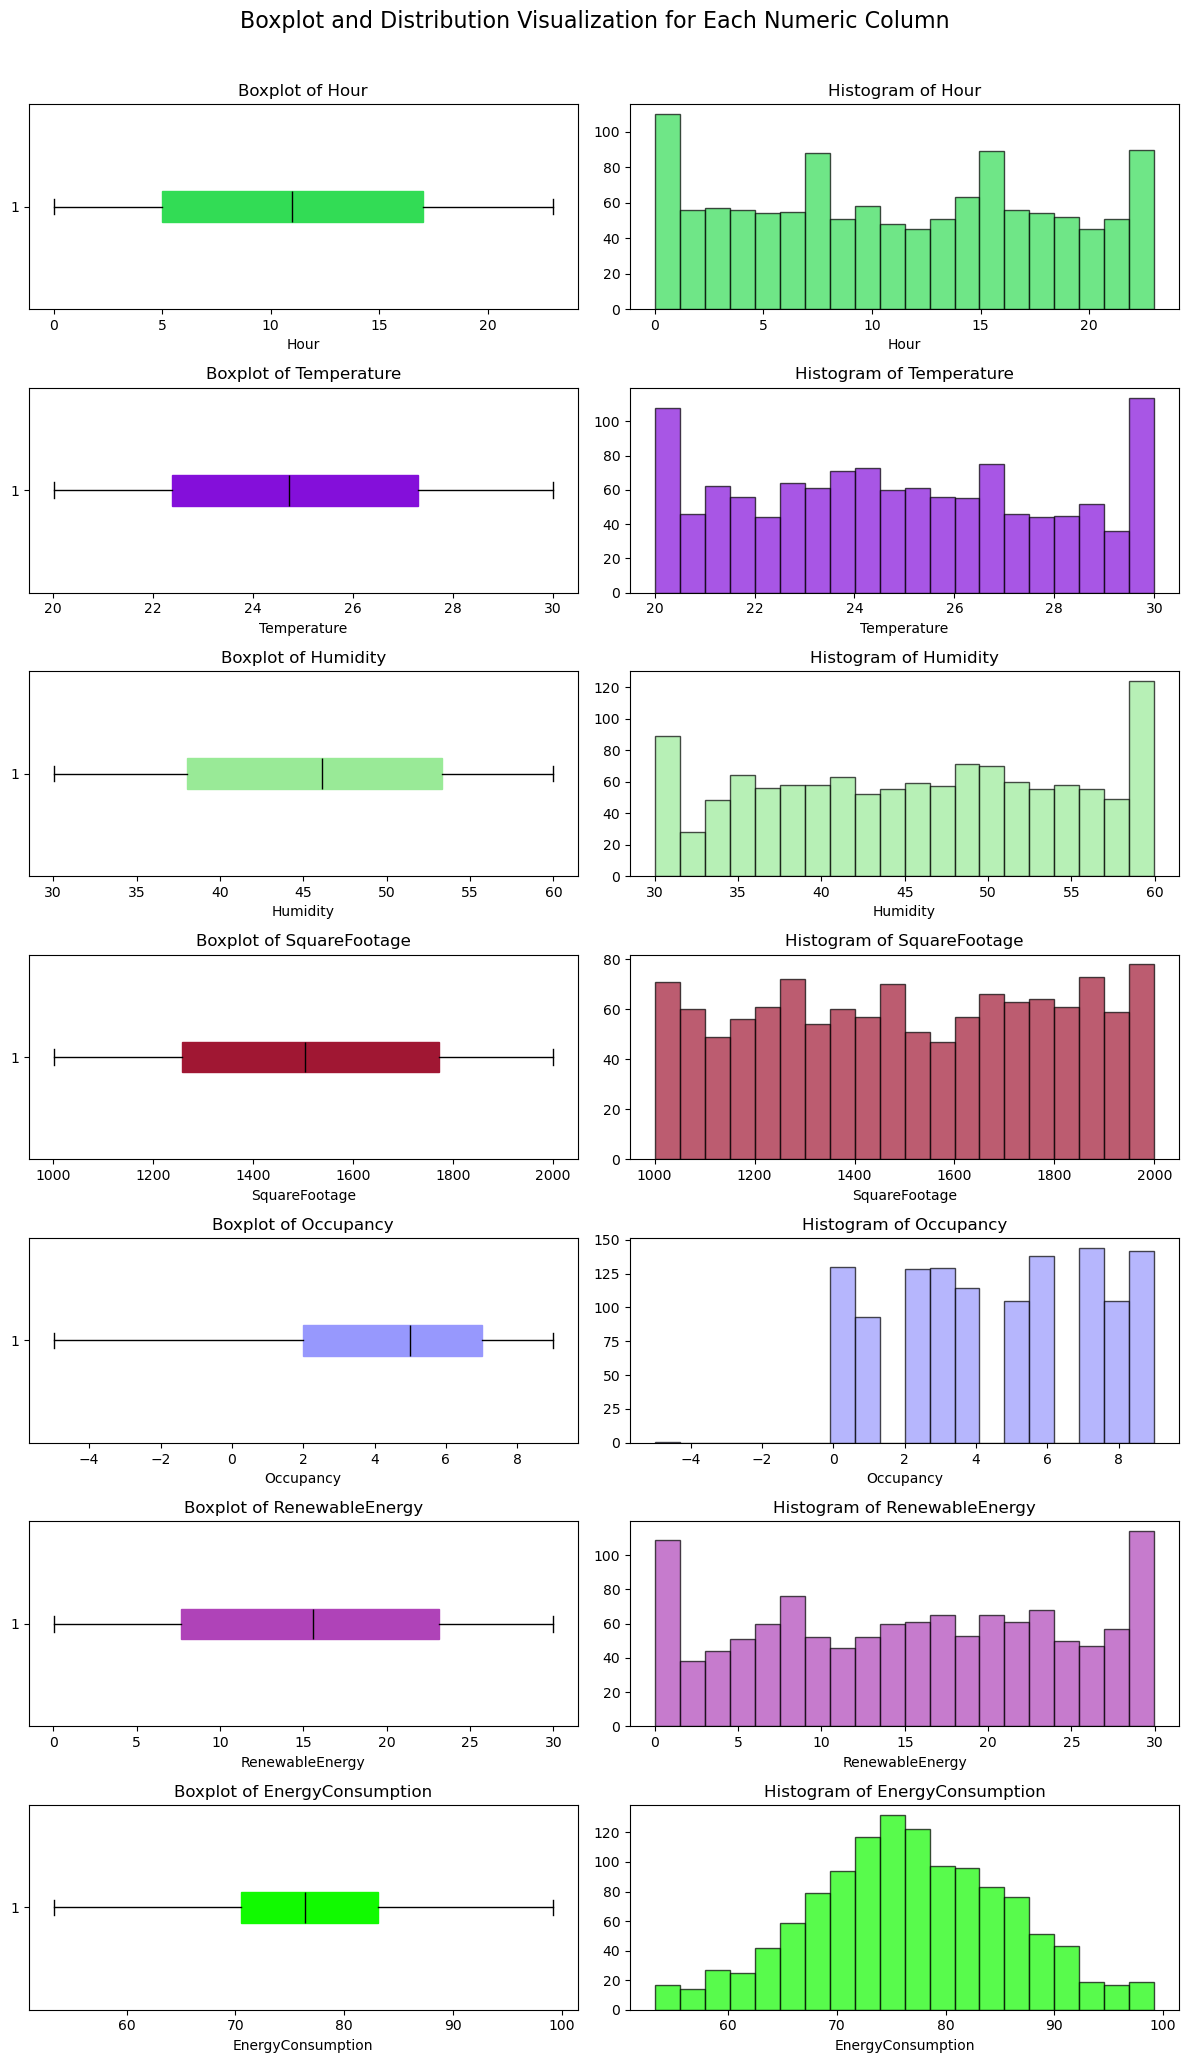

In [18]:
numeric_dist_plot(numeric_data)

#### Categorical Data Plot

In [19]:
categorical_data.head()

,Month,DayOfWeek,Holiday,HVACUsage,LightingUsage
0,8,Sunday,Yes,On,Off
1,1,Wednesday,No,On,Off
2,1,Sunday,Yes,Off,On
3,7,Wednesday,Yes,Off,On
4,10,Saturday,No,Off,Off


<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\TF_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

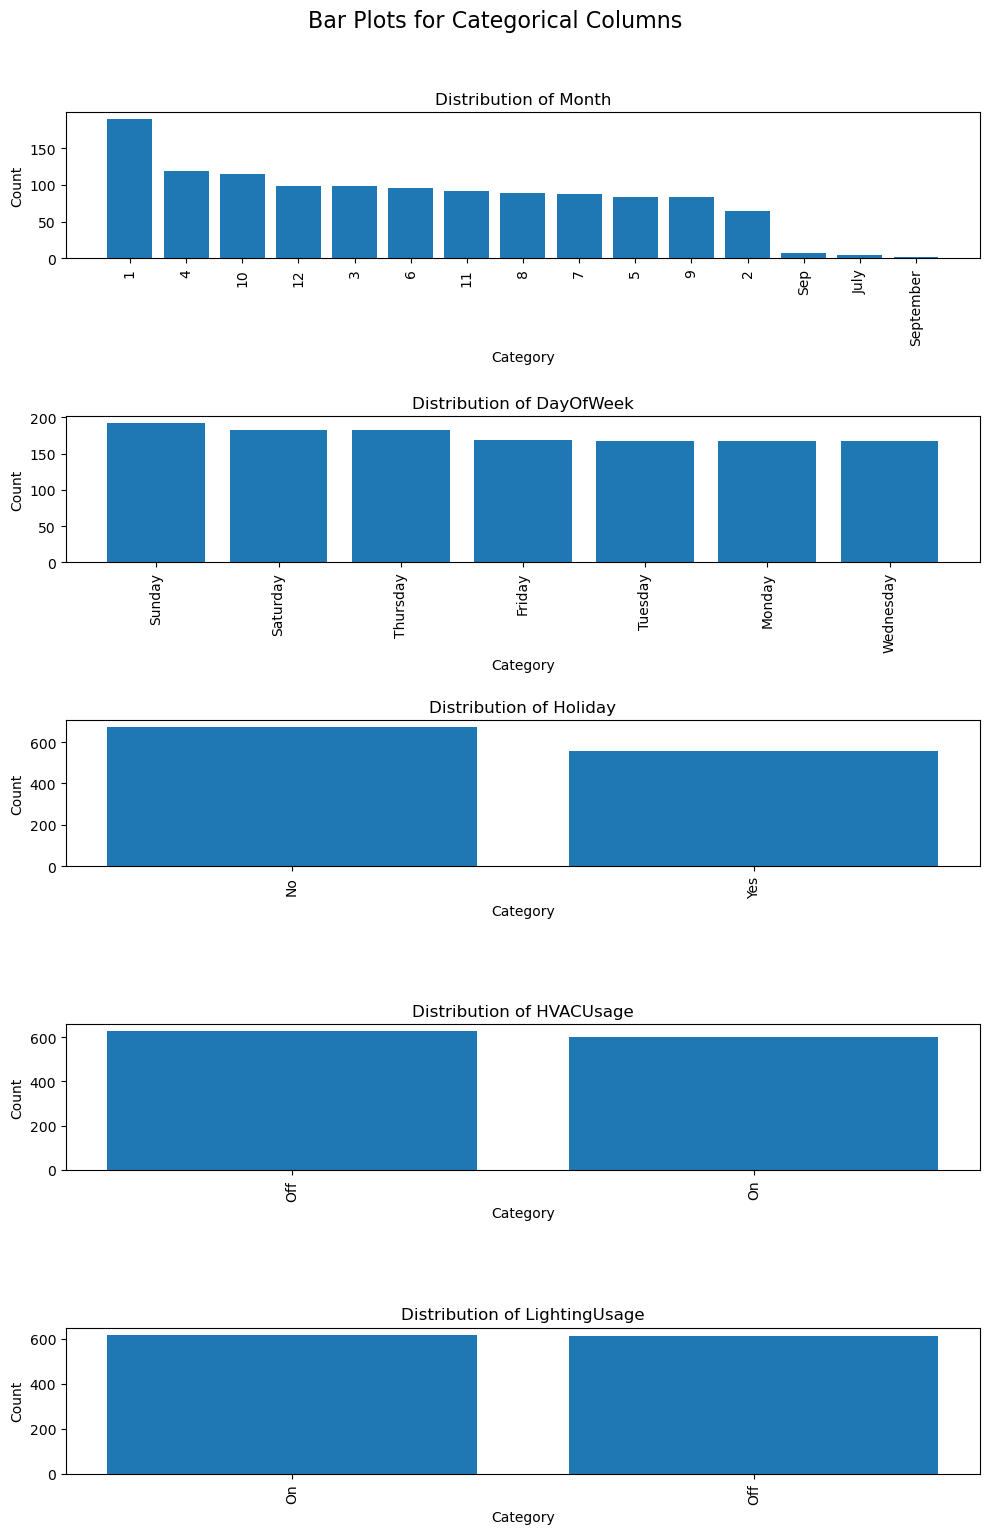

In [20]:
categoric_dist_plot(categorical_data)

### Key Insights
#### Problems With the Data
1. **Inconcistent Data Values**:
   - The months in the data is inconsistent. There are 3 types of month in the data (e.g. Numerical, partial month name, and full month name)
2. **Wierd Data Range**:
   - There seems to be a negative number of Occupancy as seen in the graph, and that is a outlier since there is nothing such as a negative number of people.
3. **Skewness**:
   - There are some skewness in the month data where there are mostly data from january. Which may impact model's performance/
   - The rest of the data are mostly uniform except for EnergyConsumption where it has a normal distribution. 

#### Small Fixes
4. **Data Types**:
- Changing the data type of "EnergyConsumption" from `object` to `float64`
- Removed Missing values from the data

#### Next Steps
- Further Clean the data due to inconsistencies

## Data Cleaning

- Standardizing the "month" data
- Cleaning the negative number of occupancy

### Standardizing the "month" data

#### String to month number

In [21]:
def str_to_month(String: str) -> str:
    """This function converts a string to a month type. The string can be in the format of "Jan", "Feb", etc. or "January", "February", etc.
    It will return the month number as a string. If the string is not in the correct format, it will return NaT.

    Args:
        String (str): The string to be converted to a month number.

    Raises:
        TypeError: 'The following value is not a string: {String}'
        This is due to the fact that the input is not a string.

    Returns:
        str: The month number as a string or NaT if the conversion failed.
    """
    # Check
    ## Check if the text is a string
    if not isinstance(String, str):
        raise TypeError(f"The following value is not a string: {String}")
    
    try:
        # If the string is already in a number format, convert it to a month number
        if String.isdecimal():
            # Check if the string is a number between 1 and 12 (january to december)
            num = int(String)
            if 1 <= num <= 12:
                dt = pd.to_datetime(num, format = '%m')
                return f"{dt.month:01d}"
            else:
                return pd.NaT
            
        # Try full month name
        try:
            dt = pd.to_datetime(String, format = '%B')  # e.g., 'January'
        except ValueError:
            dt = pd.to_datetime(String, format = '%b')  # e.g., 'Jan'

        return f"{dt.month:01d}"
    
    except Exception:
        #Return NA if the string conversion failed
        return pd.NaT

#### Apply the month to number function to the dataset

In [22]:
data["Month"] = data["Month"].apply(str_to_month)

### Cleaning the data with negative occupancy

#### Check if the data is present

In [23]:
data[data["Occupancy"] < 0]

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
975,10,4,Thursday,No,21.636782,51.998664,1442.174322,-5,On,Off,26.078521,84.024705


There is an occupancy with -5 person which is impossible since there is no such thing as negative number of persons. So removing the data would be beneficial for a cleaner data fror the deep learning model.

In [24]:
data = data.drop(data[data["Occupancy"] < 0].index).reset_index(drop=True)

### Rechecking the distribution of the data

In [25]:
categorical_data = data.select_dtypes(exclude=[np.number])
numeric_data = data.select_dtypes(include=[np.number])

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\TF_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

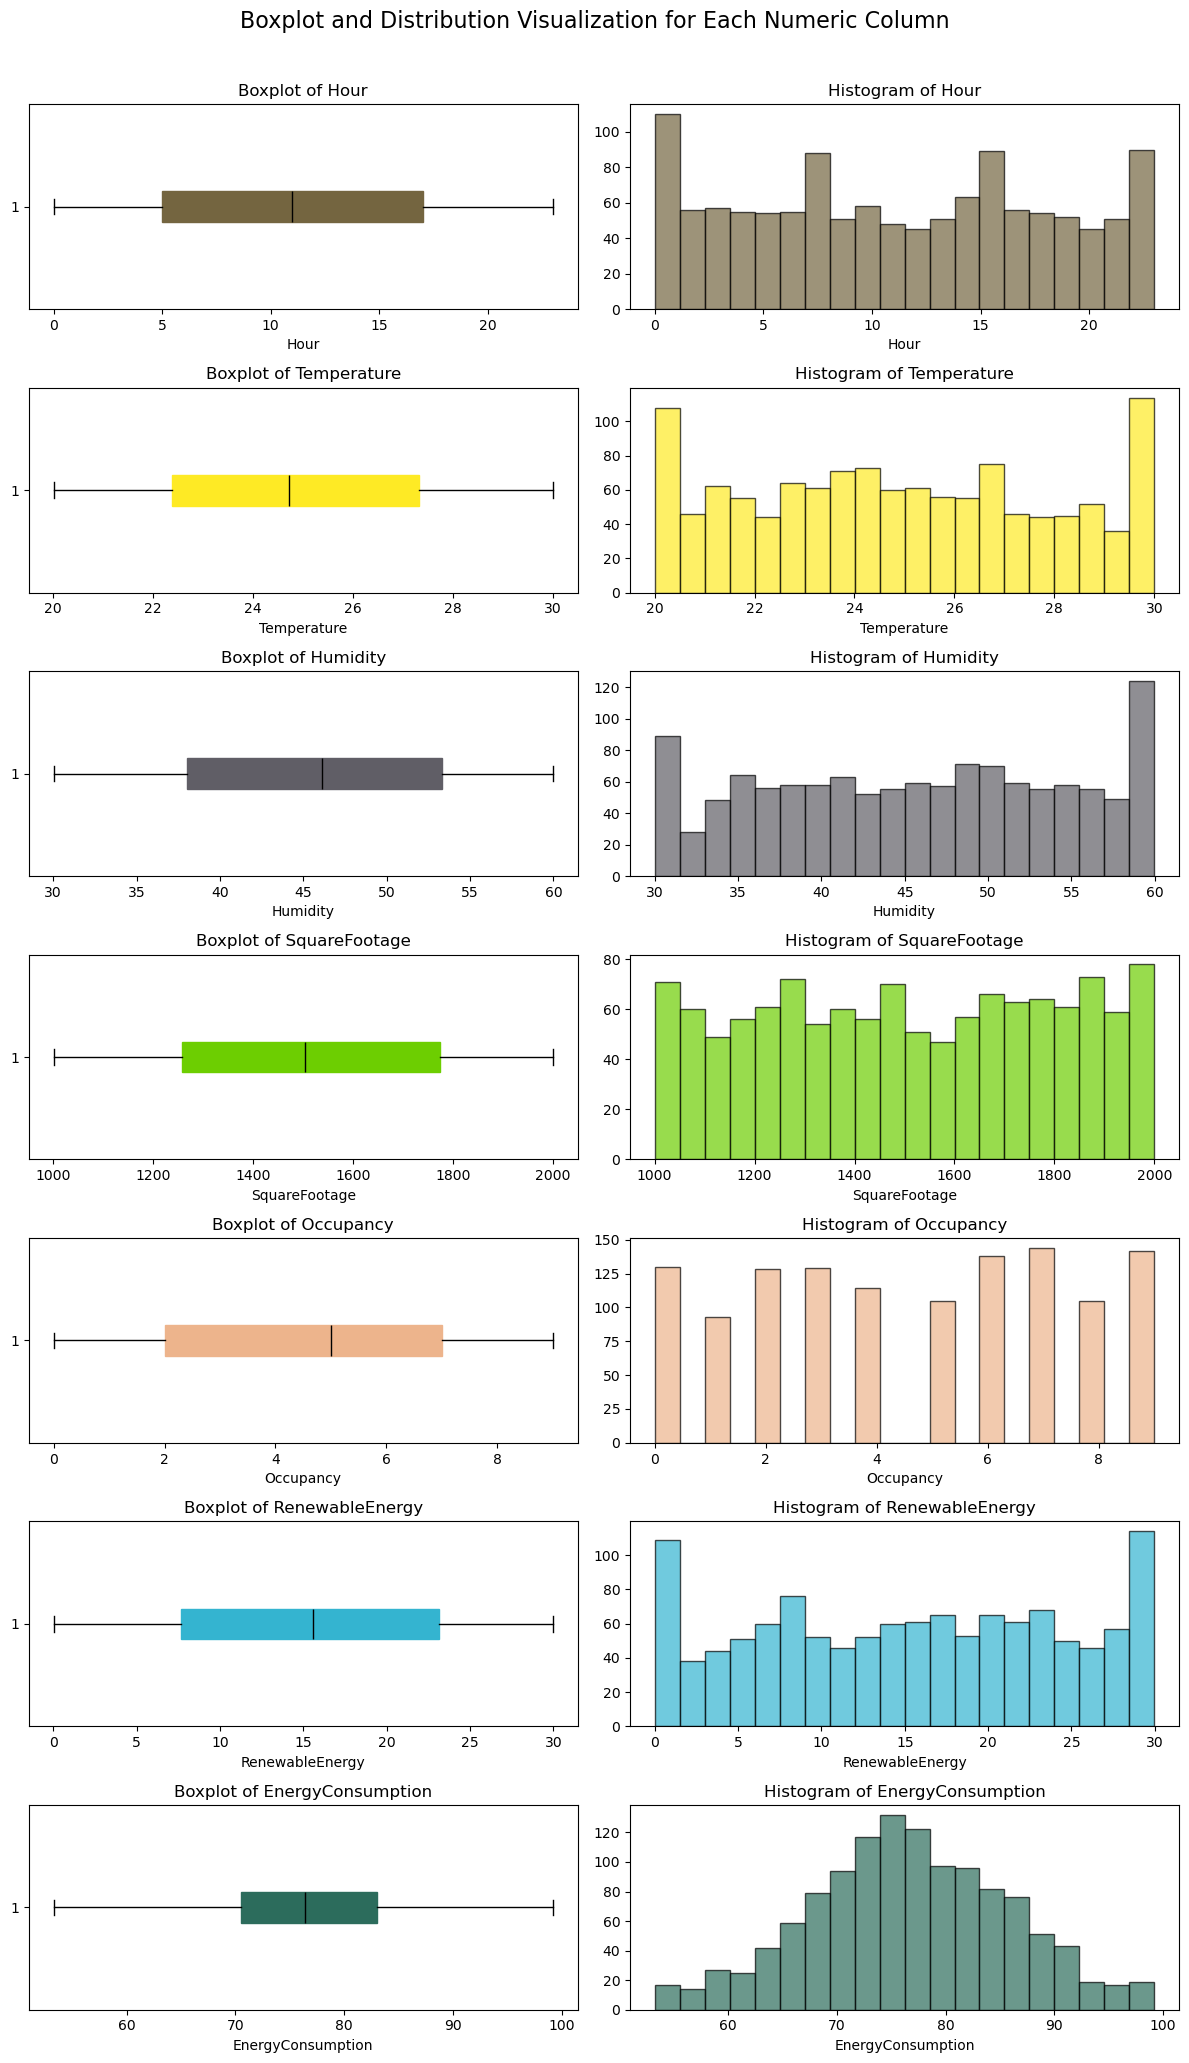

In [26]:
numeric_dist_plot(numeric_data)

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\TF_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

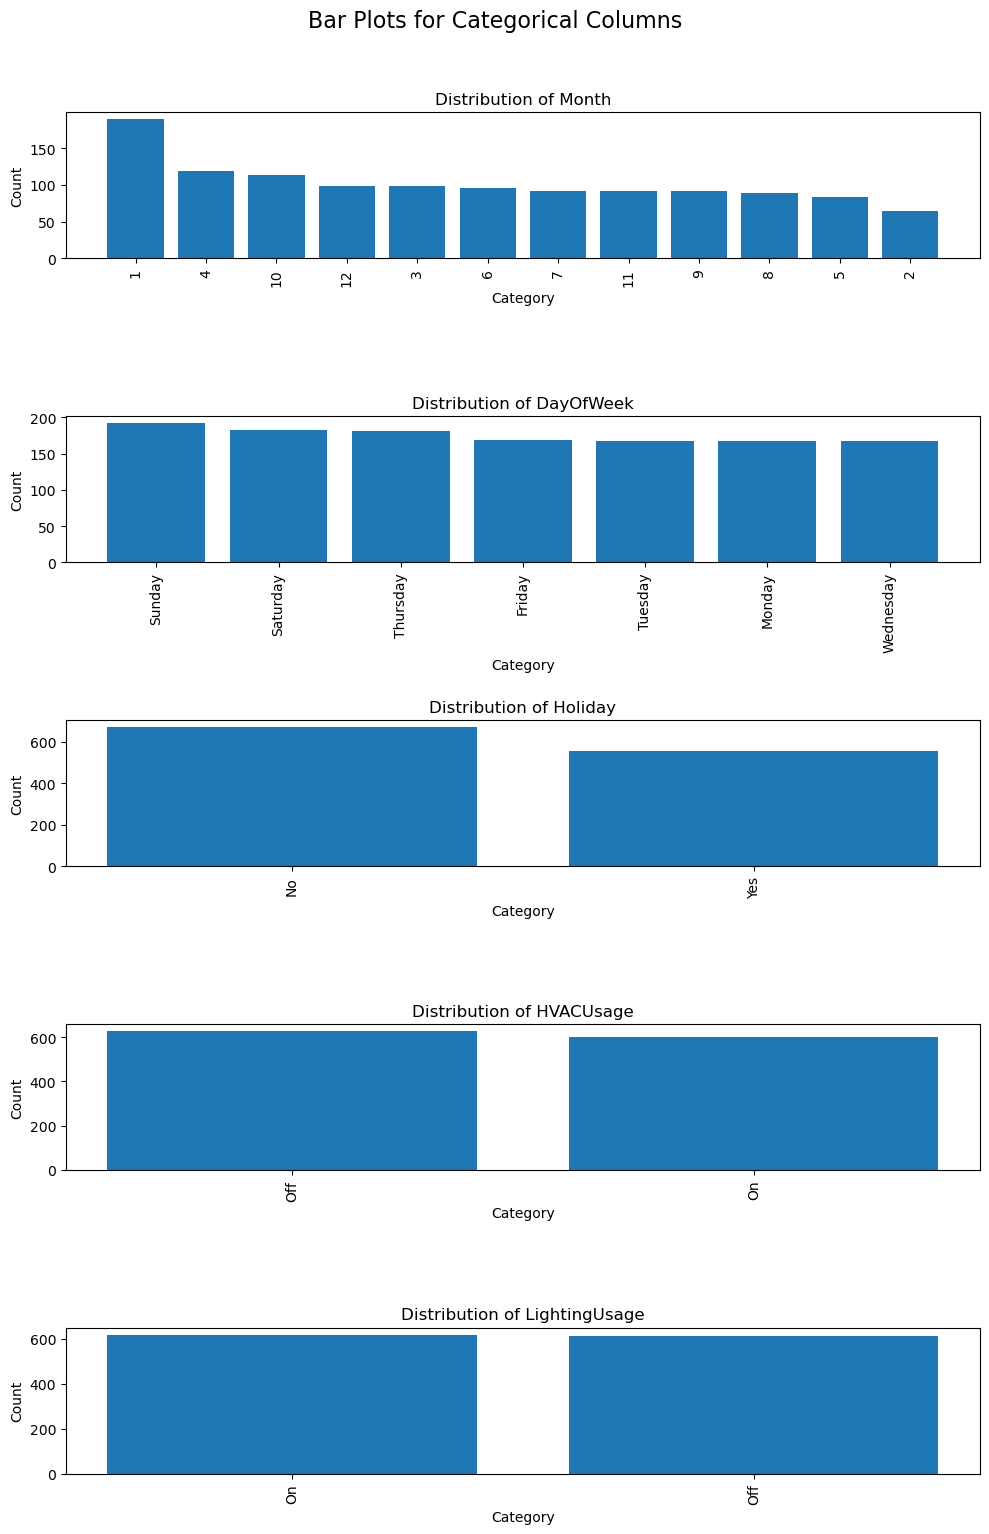

In [27]:
categoric_dist_plot(categorical_data)

### Summary Of Data Cleaning
#### Key Insights:
1. **Inconsistent Data Values**:
    - The "Month" column had inconsistent formats (e.g., numeric, full names, abbreviations), which were standardized.
2. **Outliers**:
    - Negative values in the "Occupancy" column were identified and removed.

3. **Skewness**:
    - The "EnergyConsumption" column has a normal distribution, while other numerical columns show varying degrees of skewness.

4. **Categorical Data**:
    - Some categorical columns, such as "Holiday" and "HVACUsage," have imbalanced distributions, which may impact model performance.

5. **Data Cleaning**:
    - After cleaning, the dataset is now consistent and ready for preprocessing and modeling.

#### Next Steps:
- Scale numerical data to ensure uniformity.
- Encode categorical data for compatibility with machine learning models.
- Split the data into training, validation, and testing sets for model development.

**At this point**:
- The dataset is now clean and ready for further preprocessing or modeling.
- The handling of missing values and standardization of date formats ensures consistency.

## Data Propressing

### Spitting data to train, test, and validation

#### Split data to the predictor and outcome

In [28]:
x_data = data.drop(columns=["EnergyConsumption"])
y_data = data["EnergyConsumption"]

In [29]:
# Check the columns
x_data.columns

Index(['Month', 'Hour', 'DayOfWeek', 'Holiday', 'Temperature', 'Humidity',
       'SquareFootage', 'Occupancy', 'HVACUsage', 'LightingUsage',
       'RenewableEnergy'],
      dtype='object')

In [30]:
y_data.head()

0    82.057358
1    83.889177
2    66.202098
3    66.439179
4    76.902272
Name: EnergyConsumption, dtype: float64

####  Split to train and test

In [31]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((982, 11), (246, 11), (982,), (246,))

#### Split to train and validation

In [32]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((785, 11), (197, 11), (785,), (197,))

So after splitting the data we will obtain the following:
<table>
<tr>
<th>Data</th>
<th>Size</th>
</tr>
<tr>
<td>Train</td>
<td>788</td>
</tr>
<tr>
<td>Validation</td>
<td>197</td>
</tr>
<tr>
<td>Test</td>
<td>247</td>
</tr>

### Scaling the Data

#### Scaling the numerical data

All the numerical features will use min max scaling since there are no outliers, and the data is almost uniformly distributed.

In [33]:
hoursScaler = MinMaxScaler()
tempScaler = MinMaxScaler()
humidScaler = MinMaxScaler()
squareScaler = MinMaxScaler()
occupancyScaler = MinMaxScaler()
renewableScaler = MinMaxScaler()
energyScaler = MinMaxScaler()

##### Apply to train data

In [34]:
# The x features
train_x["Hour"] = hoursScaler.fit_transform(train_x[["Hour"]])
train_x["Temperature"] = tempScaler.fit_transform(train_x[["Temperature"]])
train_x["Humidity"] = humidScaler.fit_transform(train_x[["Humidity"]])
train_x["SquareFootage"] = squareScaler.fit_transform(train_x[["SquareFootage"]])
train_x["Occupancy"] = occupancyScaler.fit_transform(train_x[["Occupancy"]])
train_x["RenewableEnergy"] = renewableScaler.fit_transform(train_x[["RenewableEnergy"]])

# The y value
train_y = energyScaler.fit_transform(train_y.values.reshape(-1, 1))

##### Apply to validation data

In [35]:
# The x features
val_x["Hour"] = hoursScaler.transform(val_x[["Hour"]])
val_x["Temperature"] = tempScaler.transform(val_x[["Temperature"]])
val_x["Humidity"] = humidScaler.transform(val_x[["Humidity"]])
val_x["SquareFootage"] = squareScaler.transform(val_x[["SquareFootage"]])
val_x["Occupancy"] = occupancyScaler.transform(val_x[["Occupancy"]])
val_x["RenewableEnergy"] = renewableScaler.transform(val_x[["RenewableEnergy"]])

# The y value
val_y = energyScaler.transform(val_y.values.reshape(-1, 1))

##### Apply to test data

In [36]:
# The x features
test_x["Hour"] = hoursScaler.transform(test_x[["Hour"]])
test_x["Temperature"] = tempScaler.transform(test_x[["Temperature"]])
test_x["Humidity"] = humidScaler.transform(test_x[["Humidity"]])
test_x["SquareFootage"] = squareScaler.transform(test_x[["SquareFootage"]])
test_x["Occupancy"] = occupancyScaler.transform(test_x[["Occupancy"]])
test_x["RenewableEnergy"] = renewableScaler.transform(test_x[["RenewableEnergy"]])

# The y value
test_y = energyScaler.transform(test_y.values.reshape(-1, 1))

### Encoding the Categorical Data

Binary Columns: `LightingUsage`, `HVACUsage`, `Holiday`

Nominal Columns: `DayOfWeek`

Ordinal Columns: `Month`

In [37]:
# The Values in the columns
for col in categorical_data.columns:
    print(f"{col}: {categorical_data[col].unique()} \n")

Month: ['8' '1' '7' '10' '4' '2' '5' '6' '11' '9' '12' '3'] 

DayOfWeek: ['Sunday' 'Wednesday' 'Saturday' 'Friday' 'Tuesday' 'Monday' 'Thursday'] 

Holiday: ['Yes' 'No'] 

HVACUsage: ['On' 'Off'] 

LightingUsage: ['Off' 'On'] 



In [38]:
binary_cols_1 = ["Holiday"]
binary_cols_2 = ["HVACUsage", "LightingUsage"] # Use Label enconder (On or Off)
nominal_cols = ["DayOfWeek"] # Use OneHotEncoder
ordinal_cols = ["Month"] # Use OrdinalEncoder

#### Encoder Setup

In [39]:
bin_enc_1 = LabelEncoder()
bin_enc_2 = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
ordinal_enc = OrdinalEncoder(categories=[["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]], handle_unknown="use_encoded_value", unknown_value=-1).set_output(transform="pandas")

#### Transforming the Train Data

##### Binary Data

In [40]:
bin_data = pd.concat([train_x[binary_cols_1].apply(bin_enc_1.fit_transform), train_x[binary_cols_2].apply(bin_enc_2.fit_transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
431,0,1,0
329,0,0,1
1051,1,1,1
22,0,1,1
1222,0,0,0


##### Nominal Data

In [41]:
nominal_data = ohe.fit_transform(train_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
431,0.0,0.0,0.0,0.0,0.0,0.0,1.0
329,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1051,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1222,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### Ordinal Data

In [42]:
ordinal_data = ordinal_enc.fit_transform(train_x[ordinal_cols])
ordinal_data.head()

,Month
431,4.0
329,7.0
1051,9.0
22,10.0
1222,0.0


##### Reunite the dataset

In [43]:
train_x = pd.concat([train_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
train_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
431,0.869565,0.635707,1.000000,1.000000,0.000000,0.004840,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
329,0.173913,0.987916,1.000000,0.154359,0.666667,0.881296,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1051,0.000000,0.247066,0.385912,0.330254,0.222222,0.432479,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
22,0.000000,0.820101,0.694746,0.324268,0.333333,0.559751,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0
1222,0.608696,0.682566,0.763241,0.262256,0.333333,0.803954,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Transforming the Validation Data

##### Binary Data

In [44]:
bin_data = pd.concat([val_x[binary_cols_1].apply(bin_enc_1.transform), val_x[binary_cols_2].apply(bin_enc_2.transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
186,1,0,0
928,0,1,1
863,1,0,0
167,1,0,0
136,1,1,1


##### Nominal Data

In [45]:
nominal_data = ohe.transform(val_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
186,0.0,0.0,1.0,0.0,0.0,0.0,0.0
928,0.0,0.0,0.0,0.0,1.0,0.0,0.0
863,0.0,1.0,0.0,0.0,0.0,0.0,0.0
167,0.0,0.0,1.0,0.0,0.0,0.0,0.0
136,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### Ordinal Data

In [46]:
ordinal_data = ordinal_enc.transform(val_x[ordinal_cols])
ordinal_data.head()

,Month
186,3.0
928,0.0
863,3.0
167,7.0
136,11.0


##### Reunite the dataset

In [47]:
val_x = pd.concat([val_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
val_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
186,0.173913,0.677827,0.922215,0.000000,0.333333,0.423396,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
928,0.173913,0.203936,0.110449,0.734958,0.000000,0.493151,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
863,0.869565,0.877667,0.509860,0.546393,0.222222,0.266117,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
167,0.782609,0.570794,0.228420,0.899237,0.444444,0.306755,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
136,0.565217,0.593852,1.000000,0.792945,0.444444,0.288517,1,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0


#### Transforming the Test Data

##### Binary Data

In [48]:
bin_data = pd.concat([test_x[binary_cols_1].apply(bin_enc_1.transform), test_x[binary_cols_2].apply(bin_enc_2.transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
710,0,0,1
486,1,0,0
244,1,0,0
551,1,0,0
1162,1,1,0


##### Nominal Data

In [49]:
nominal_data = ohe.transform(test_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
710,0.0,1.0,0.0,0.0,0.0,0.0,0.0
486,0.0,0.0,0.0,0.0,0.0,1.0,0.0
244,0.0,0.0,0.0,0.0,1.0,0.0,0.0
551,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1162,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Ordinal Data

In [50]:
ordinal_data = ordinal_enc.transform(test_x[ordinal_cols])
ordinal_data.head()

,Month
710,0.0
486,3.0
244,2.0
551,4.0
1162,9.0


##### Reunite the dataset

In [51]:
test_x = pd.concat([test_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
test_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
710,0.913043,0.072880,0.617320,0.836474,0.444444,0.310054,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
486,0.043478,0.583121,0.564254,0.896841,0.666667,0.546465,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
244,0.565217,0.509140,0.006289,0.815548,0.333333,0.949764,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
551,0.217391,0.479635,0.635156,0.559464,0.888889,0.770393,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
1162,0.565217,0.567467,0.223269,0.082053,0.111111,0.000000,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0


## Model making

# E

<img src="haybale-rolling.gif">

bla bla bla <br>
bli bli bli <br>
blu blu blu <br>
hop <br>
blu blu blu blu blu blu <br>
blu blu blu blu blu blu <br>
blu blu blu blu blu blu <br>
blu blu blu blu blu blu <br>
blu blu blup<br>
ling gang guli guli guli wata <br>
wata ling gang gu <br>
ling gang gu <br>
ling gang guli guli guli wata <br>
wata ling gang gu <br>
ling gang gu <br>
ling gang guli guli guli wata <br>
wata ling gang gu <br>
ling gang gu